In [ ]:
!pip install gradio
!pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#bibliotecas necessárias para o projeto
import os
import string
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


import gradio as gr
import re
import os
import librosa
import librosa.display
from gtts import gTTS

In [ ]:
#como os arquivos estão na nuvem precisamos do Gdrive
from google.colab import drive

In [ ]:
#carregga os dados...
drive.mount('/content/drive/')

image_dir = '/content/drive/MyDrive/Images'
save_dir = '/content/drive/MyDrive/trab_pln'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Modelo e extração de dados.

In [ ]:
#Carregar o modelo vgg16
model = VGG16() #VGG16 é uma arquitetura de rede neural de convolução (CNN) para reconhecimento de imagem em larga escala
#Reestruturar o modelo
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#Resumir
print(model.summary())
#No final, possui 2 FC (camadas totalmente conectadas) seguidas por um softmax para saída. 
#O 16 em VGG16 refere-se a 16 camadas que possuem pesos. 
#Esta rede é bastante grande e tem cerca de 138 milhões (aproximadamente) de parâmetros.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

#Extrai recursos da imagem
'''
features = {}
directory = os.path.join(image_dir)


for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    '''

"\nfeatures = {}\ndirectory = os.path.join(image_dir)\n\n\nfor img_name in tqdm(os.listdir(directory)):\n    # load the image from file\n    img_path = directory + '/' + img_name\n    image = load_img(img_path, target_size=(224, 224))\n    # convert image pixels to numpy array\n    image = img_to_array(image)\n    # reshape data for model\n    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))\n    # preprocess image for vgg\n    image = preprocess_input(image)\n    # extract features\n    feature = model.predict(image, verbose=0)\n    # get image ID\n    image_id = img_name.split('.')[0]\n    # store feature\n    features[image_id] = feature\n    "

In [ ]:
# Armazenar recursos
'''
pickle.dump(features, open(os.path.join(save_dir, 'features.pkl'), 'wb'))
'''

"\npickle.dump(features, open(os.path.join(save_dir, 'features.pkl'), 'wb'))\n"

In [ ]:
# carregar recursos
with open(os.path.join(save_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)


#Carregando as descrições das imagens

In [ ]:
arquivo = open('/content/drive/MyDrive/Flickr8k.token.txt','r')

In [ ]:
def carrega_arquivo(arquivo):
  texto = []
  for linha in tqdm(arquivo):
    texto.append(linha)
  return texto

In [ ]:
doc = carrega_arquivo(arquivo)

0it [00:00, ?it/s]

In [ ]:
for i in range(10):
  print(doc[i])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting

1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .

1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .

1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .

1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .



# Pré processamento

In [ ]:
def carrega_descricao(arquivo):
  #criando o dicicionario de descrições
  descricao = dict()
  for line in arquivo:
    #codigo da imagem
    image_id = line.split('\t')[0]
    #descricao da imagem
    image_desc = line.split('\t')[1]
    image_desc = image_desc.split('\n')[0]
    #limpa o codigo da imagem
    image_id = image_id.split('.')[0]
    # converte tokens de descrição de volta para string
    
    #image_desc = ' '.join(image_desc)
    #caso a chave não exista no dict ele cria.
    if image_id not in descricao:
      descricao[image_id] = list()
    #adiciona a descrição ao dict
    descricao[image_id].append(image_desc)
    #print(image_id)
    #print(image_desc)
  return descricao

In [ ]:
descriptions = carrega_descricao(doc)
print("Quantidade de imagens: ",len(descriptions))

Quantidade de imagens:  8091


In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def limpa_descricao(descricao):
  pontuacao = str.maketrans('','',string.punctuation)
  for key, desc_list in tqdm(descricao.items()):
    for i in range(len(desc_list)):
      aux = desc_list[i]
      #tokeniza
      aux = aux.split()
      #minusculo
      aux = [word.lower() for word in aux]
      #remove pontuacao
      aux = [word.translate(pontuacao) for word in aux]
      #remove apóstrofo, e artifo em ingês
      aux = [word for word in aux if len(word)>1]
      #remove numero
      aux = [word for word in aux if word.isalpha()]
      #armazena como string
      desc_list[i] = " ".join(aux)
      #print(desc_list[i])
      #print(aux)

In [ ]:
limpa_descricao(descriptions)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
#após a limpeza
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
#incluindo startseq e endseq

for key, desc_list in descriptions.items():
  for i in range(len(desc_list)):
    desc_list[i] = 'startseq ' + desc_list[i] + " endseq"

In [ ]:
#após o tratamento
descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in descriptions:
  for caption in descriptions[key]:
    all_captions.append(caption)

In [ ]:
all_captions[0:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
print('Tamanho das descrições: ',len(all_captions))

Tamanho das descrições:  40455


#Tokeniza as descrições

In [ ]:
#tokeniza as descrições
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)# fit_on_texts: atualiza o vocabulário interno com base nas listas de textos
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8766

In [ ]:

# obtém o tamanho máximo da legenda disponível
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

#Train Test Split

In [ ]:
image_ids = list(descriptions.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
len(train)

7281

In [ ]:
len(test)

810

In [ ]:
# cria gerador de dados para obter dados em lote (evita travamento da sessão)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop sobre as imagens
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # processar cada legenda
            for caption in captions:
                # codifica a sequência
                seq = tokenizer.texts_to_sequences([caption])[0]
                # divide a sequência em pares X, y
                for i in range(1, len(seq)):
                    # dividido em pares de entrada e saída
                    in_seq, out_seq = seq[:i], seq[i]
                    # sequência de entrada de pad
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # codifica a sequência de saída
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # armazena as sequências
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

#Criação do Modelo

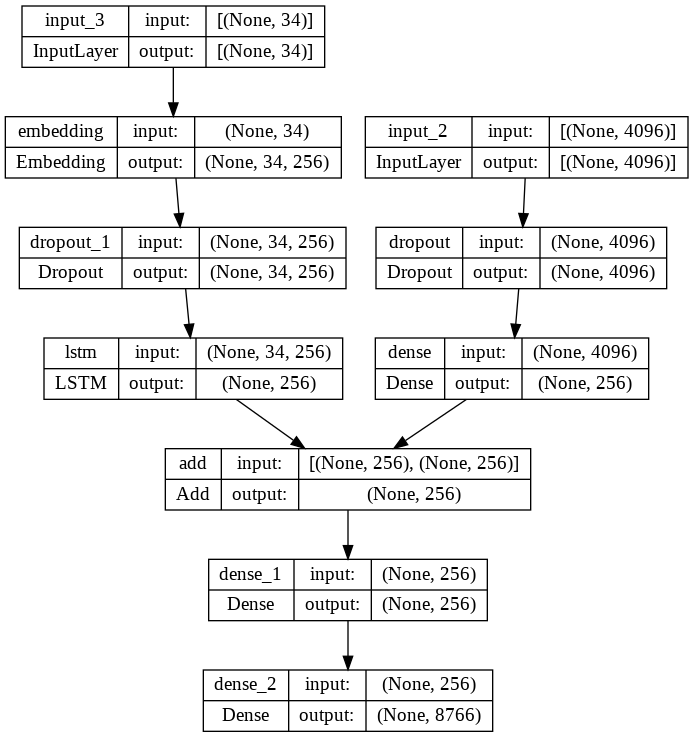

In [ ]:
# modelo de codificador
# camadas de recurso de imagem
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# camadas de feição de sequência
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# modelo do decodificador
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plotar o modelo
plot_model(model, show_shapes=True)


In [ ]:
# treina o modelo
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # criar gerador de dados
    generator = data_generator(train, descriptions, features, tokenizer, max_length, vocab_size, batch_size)
    # adequando para uma época
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)



227/227 [==============================] - 53s 235ms/step - loss: 2.1686


In [ ]:
# save the model
#model.save(save_dir+'/best_model')


#Gera legenda para imagem

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items(): #tokenizer.word_index.items(): retorna uma lista de tuplas
        if index == integer: #se o index for igual ao inteiro
            return word
    return None

In [ ]:
# gera legenda para uma imagem
def predict_caption(model, image, tokenizer, max_length):
    # adicionar marca de início para processo de geração
    in_text = 'startseq'
    # iterar sobre o comprimento máximo da sequência
    for i in range(max_length):
        # codifica a sequência de entrada
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # preenche a sequência
        sequence = pad_sequences([sequence], max_length)
        # prever a próxima palavra
        yhat = model.predict([image, sequence], verbose=0)
        # obtém índice com alta probabilidade
        yhat = np.argmax(yhat)
        # converte índice em palavra
        word = idx_to_word(yhat, tokenizer)
        # pare se a palavra não for encontrada
        if word is None:
            break
        # anexa a palavra como entrada para gerar a próxima palavra
        in_text += " " + word
        # pare se atingirmos a tag final
        if word == 'endseq':
            break
      
    return in_text


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validar com dados de teste
actual, predicted = list(), list()

for key in tqdm(test):
    # obter legenda real
    captions = descriptions[key]
    # prevê a legenda da imagem
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # divide em palavras
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # acrescenta à lista
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcula a pontuação BLEU
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
#O BLEU score compara uma sentença com uma ou mais sentenças de referência 
#e informa o quão bem a sentença candidata corresponde à lista de sentenças de referência. Dá uma pontuação de saída entre 0 e 1.
#Um BLEU score de 1 significa que a frase candidata corresponde perfeitamente a uma das frases de referência.

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.509573
BLEU-2: 0.291818


#Visualização dos resultados

In [ ]:
def search_file(file_name):

    for root, dirs, files in os.walk(os.getcwd()): # os.getcwd() returns current working directory
        if file_name in files: # if file_name is in files list
            return os.path.join(root, file_name) # return the path of the file
    return None

In [ ]:
def get_filename(file_obj):
    
    regex = '[0-9]{8,10}_[a-z0-9]{9,10}'
    clear_code = re.findall(regex, file_obj.name)[0]

    return clear_code

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  
    # load the image
    
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_dir, image_name)
    image = Image.open(img_path)
    captions = descriptions[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    return y_pred
    

In [ ]:
from gtts import gTTS
def image_audio(image):
    
    input = image.name.split('\\')[-1]
    #print("Meu novo nome é ", input)

    regex = '[0-9]{8,10}_[a-z0-9]{9,10}'

    input = re.findall(regex, input)[0]
    input = input + '.jpg'
    #input vai ser usado no PREDICT
    #corrige o output do predict
    
    y_pred = generate_caption(input)
    print(y_pred)
    y_pred = y_pred.replace('startseq', '').replace('endseq', '').strip()

    #transforma o predict em audio
    tts = gTTS(text=y_pred, lang='en')
    tts.save("audio.mp3")

    #acha o caminho do audio 
    path = search_file("audio.mp3")
    print(path)
    return path


iface = gr.Interface(fn=image_audio, inputs="file", outputs="audio")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

---------------------Actual---------------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse lead behind fire endseq
startseq man and girl and two horses are near contained fire endseq
startseq two people and two horses watching fire endseq
--------------------Predicted--------------------
startseq two horses are standing by contained fire endseq


'startseq two horses are standing by contained fire endseq'

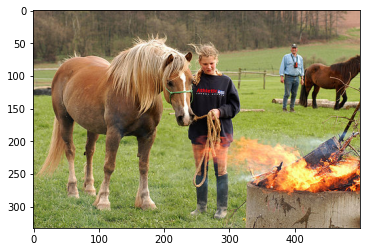

In [ ]:
generate_caption("10815824_2997e03d76.jpg")